A notebook which contains timeseries of SalishSeaCast model output and observed data within PugetSound for the year 2009. This script is designed so that model and observed data can be easily compared across multiple different stations. 

In [3]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [4]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import xarray as xr
import datetime as dt
import Keegan_eval_tools as ket
from salishsea_tools import evaltools as et, viz_tools
from collections import OrderedDict
from scipy.interpolate import make_interp_spline, BSpline

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [5]:
year=2010
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [6]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2010

In [7]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

In [8]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'

with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{year}.pkl'),'rb') as hh:
    data=pickle.load(hh)
    
with open(os.path.join(saveloc,f'data_Pheo_{modelversion}_{year}.pkl'),'rb') as hh:
    data_Pheo=pickle.load(hh)

In [9]:
def TsByRegion(datreg,regions,obsvar,modvar,year,loc='lower left',units='($\mu$M)'):
    fig,ax=plt.subplots(math.ceil(len(regions)/2),2,figsize=(13,13))
    new_reg = [regions[i:i+2] for i in range(0, len(regions), 2)]
    for ri,axi in zip(new_reg,ax):
        for rj,axj in zip(ri,axi):
            ps=ket.tsertser_graph(axj,datreg[rj],obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
            axj.legend(handles=ps,prop={'size': 10},loc=loc)
            axj.set_xlabel(f'Date',fontsize=13)
            axj.set_ylabel(f'{obsvar} {units}',fontsize=13)
            axj.set_title(f'Time series for {rj}', fontsize=13)
            yearsFmt = mdates.DateFormatter('%d %b')
            axj.xaxis.set_major_formatter(yearsFmt)
            for tick in axj.xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            for tick in axj.yaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            plt.tight_layout()
            plt.setp(axj.get_xticklabels(), rotation=30, horizontalalignment='right')

def TsByDepth(df,obsvar,modvar,year,title,units='($\mu$M)'):
    fig,ax=plt.subplots(1,1,figsize=(18,8))
    ps=ket.tsertser_graph(ax,df,obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
    ax.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
    ax.set_xlabel(f'Date',fontsize=20)
    ax.set_ylabel(f'{obsvar} {units}',fontsize=20)
    ax.set_title(f'{title}', fontsize=22)
    yearsFmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(yearsFmt)

# I know I found a solution to this problem of mine in the past that     
    
def TsByStation(df,region,datstat,obsvar,modvar,year):
    for s,a in df[df.Basin == region].Station.unique():
        fig,ax=plt.subplots(1,1,figsize=(18,8))
        ps=ket.tsertser_graph(ax,datstat[s],obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
        ax.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
        ax.set_xlabel(f'Date',fontsize=20)
        ax.set_ylabel(f'{obsvar} ($\mu$M)',fontsize=20)
        ax.set_title(f'{s}', fontsize=22)
        yearsFmt = mdates.DateFormatter('%d %b')
        ax.xaxis.set_major_formatter(yearsFmt)

In [10]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

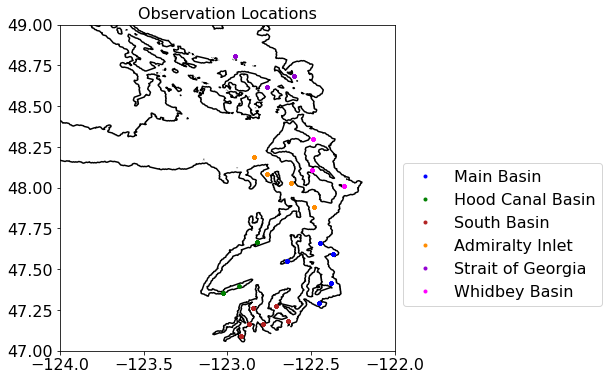

In [11]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

In [12]:
#creating new dictionaries that make it easy to call on specific years.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion] 
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]
    
#Adding extra columns to assist in chlorophyll analysis.
data_Pheo['log_Chl']=ket.logt(data_Pheo['Chla_Lab'])
data_Pheo['log_mod_diatoms']=ket.logt(data_Pheo['mod_diatoms']*1.8)
data_Pheo['log_mod_ciliates']=ket.logt(data_Pheo['mod_ciliates']*1.8)
data_Pheo['log_mod_flagellates']=ket.logt(data_Pheo['mod_flagellates']*1.8)
data_Pheo['mod_Chl']=((data_Pheo['mod_diatoms']*1.8)+(data_Pheo['mod_ciliates']*1.8)+(data_Pheo['mod_flagellates']*1.8))
data_Pheo['log_mod_Chl']=ket.logt((data_Pheo['mod_diatoms']*1.8)+(data_Pheo['mod_ciliates']*1.8)+(data_Pheo['mod_flagellates']*1.8))

# defning a dictionary that brakes the data down by individual stations
datstat_Pheo=dict()
for ind, istation in enumerate(data_Pheo.Station.unique()):
    datstat_Pheo[istation]=data_Pheo.loc[data_Pheo.Station == istation]

datreg_Pheo=dict()
for iregion in data_Pheo.Basin.unique():
    datreg_Pheo[iregion] = data_Pheo.loc[data_Pheo.Basin==iregion] 
    
datyear_Pheo=dict()
for iyear in data_Pheo.dtUTC.dt.year.unique():
    datyear_Pheo[iyear] = data_Pheo.loc[data_Pheo.dtUTC.dt.year==iyear]

In [35]:
data.columns

Index(['Station', 'Desig', 'Descrip', 'Basin', 'Max_Depth', 'Lat', 'Lon',
       'Date', 'dtUTC', 'Z', 'PO4(uM)D', 'SiOH4(uM)D', 'NO3(uM)D', 'NO2(uM)D',
       'NH4(uM)D', 'DIN', 'Znom', 'NO23', 'Amm', 'Si', 'Year', 'YD', 'SA',
       'CT', 'j', 'i', 'mod_nitrate', 'mod_silicon', 'mod_ammonium',
       'mod_diatoms', 'mod_ciliates', 'mod_flagellates', 'mod_votemper',
       'mod_vosaline', 'k'],
      dtype='object')

In [25]:
def TsByStation_full (ax,df,region,obsvar,modvar,units='($\mu$M)',omark='o',mmark='x',
                 cols=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
                'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')):
    ps = []
    for ind, istation in enumerate(df[df['Basin'] == region].Station.unique()):  
        obs0=et._deframe(df.loc[(df['Station'] == istation),[obsvar]])
        mod0=et._deframe(df.loc[(df['Station'] == istation),[modvar]])
        time0=et._deframe(df.loc[(df['Station'] == istation),['YD']])
        p0,=ax.plot(time0,obs0,'.',color=cols[ind],marker=omark,label=f'{istation} obs',fillstyle='none',alpha=0.5)
        ps.append(p0)
        p0,=ax.plot(time0,mod0,'.',color=cols[ind],marker=mmark,label=f'{istation} mod',fillstyle='none',alpha=0.5)
        ps.append(p0)
    yearsFmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(yearsFmt)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.set_title(f'{obsvar} {units} in {region} by Station')
    legend = plt.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
    plt.gca().add_artist(legend)
    return ps

def ts_trendline (ax,df,region,obsvar,modvar):
    yd=[]
    ps=[]
    df=df.sort_values(by='dtUTC').dropna()
    obs0=et._deframe(df.loc[(df['Basin'] == region),[obsvar]])
    mod0=et._deframe(df.loc[(df['Basin'] == region),[modvar]])
    timepy=df[df['Basin'] == region].dtUTC.dt.to_pydatetime()
    time0=et._deframe(timepy)
    for i in time0:
        yd.append((i - dt.datetime(i.year, 1, 1)).days + 1)
    coefso = poly.polyfit(yd,obs0,4)
    ffito = poly.polyval(yd, coefso)
    coefsm = poly.polyfit(yd,mod0,4)
    ffitm = poly.polyval(yd, coefsm)
    p0,=ax.plot(time0, ffito, color='blue', label='Observed')
    ps.append(p0)
    p0,=ax.plot(time0, ffitm, color='fuchsia', label='Modeled')
    ps.append(p0)
    ax.legend(handles=ps,bbox_to_anchor=[1,.8,0,0])

def TsByStation_ind (df,datstat,regions,obsvar,modvar,year,ylim,figsize=(14,40),ByDepth=False,depth_range=(15,22)):  
    stations=[]
    ps=0
    for r in regions:
        sta0=df[df['Basin']==r].Station.unique()
        stations.append(sta0)
    stations = [val for sublist in stations for val in sublist]
    fig,ax=plt.subplots(math.ceil(len(stations)/2),2,figsize=figsize)
    new_stat = [stations[i:i+2] for i in range(0, len(stations), 2)]
    for si,axi in zip(new_stat,ax):
        for sj,axj in zip(si,axi):
            if ByDepth == False:
                ps=ket.tsertser_graph(axj,datstat[sj],obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31))
            elif ByDepth == True:
                ps=ket.tsertser_graph(axj,datstat[sj],obsvar,modvar,dt.datetime(year,1,1),dt.datetime(year,12,31),'Z',depth_range,'z','m')
            axj.legend(handles=ps,prop={'size': 10},bbox_to_anchor=[1,.6,0,0])
            axj.set_xlabel(f'Date',fontsize=13)
            axj.set_ylabel(f'{obsvar} ($\mu$M)',fontsize=13)
            axj.set_title(f'{df[df.Station==sj].Basin.unique()[0]} ({sj})', fontsize=13)
            axj.set_ylim(ylim)
            yearsFmt = mdates.DateFormatter('%d %b')
            axj.xaxis.set_major_formatter(yearsFmt)
            for tick in axj.xaxis.get_major_ticks():
                tick.label.set_fontsize(11)
            for tick in axj.yaxis.get_major_ticks():
                tick.label.set_fontsize(11)
            plt.tight_layout()
            plt.setp(axj.get_xticklabels(), rotation=30, horizontalalignment='right')

In [40]:
def ts_spline_line(ax,df,obsvar,modvar,start_date,end_date,sepvar='',sepvals=([]),lname='',sepunits='',
                  ocols=('blue','darkviolet','teal','green','deepskyblue'),
                  mcols=('fuchsia','firebrick','orange','darkgoldenrod','maroon'),labels=''):
    """ Plots trendlines by adding line plots to axes ax with df['dtUTC'] on x-axis, 
        df[obsvar] and df[modvar] on y axis, and colors taken from a listas determined from 
        df[sepvar] and a list of bin edges, sepvals. Trendlines are calculated by fitting a 
        4 dimensional polynomial to the data. 
    """
    if len(lname)==0:
        lname=sepvar
    ps=list()
    df=df.sort_values(by='dtUTC')
    df=df.dropna(axis=0,subset=[obsvar,modvar,'dtUTC'])
    dfg=df.groupby(by='dtUTC')
    df_mean=dfg.mean()
    df_mean['yearday']=df_mean.index.dayofyear
    df_mean=df_mean.reset_index()
    if len(sepvals)==0:
        obs0=et._deframe(df_mean.loc[(df_mean['dtUTC'] >= start_date)&(df_mean['dtUTC']<= end_date),[obsvar]])
        mod0=et._deframe(df_mean.loc[(df_mean['dtUTC'] >= start_date)&(df_mean['dtUTC']<= end_date),[modvar]])
        time0=et._deframe(df_mean.loc[(df_mean['dtUTC'] >= start_date)&(df_mean['dtUTC']<= end_date),['yearday']])
        tnew = np.linspace(time0.min(), time0.max(), 300) 
        ospl = make_interp_spline(time0, obs0, k=3)  # type: BSpline
        mspl = make_interp_spline(time0, mod0, k=3)
        obs_smooth = ospl(tnew)
        mod_smooth = mspl(tnew)
        p0,=ax.plot(tnew, obs_smooth, color=ocols[0], label=f'Observed {lname}',alpha=0.7, linestyle='dashed')
        ps.append(p0)
        p0,=ax.plot(tnew, mod_smooth, color=mcols[0], label=f'Modeled {lname}',alpha=0.7, linestyle='dashed')
        ps.append(p0)

# If you are going to do the averages than you need to average by day. Trying to average all the way down to the second is creating a storm of BS.
def ts_avg_line(ax,df,obsvar,modvar,start_date,end_date,region,sepvar='',sepvals=([]),lname='',sepunits='',
                  ocols=('blue','darkviolet','teal','green','deepskyblue'),
                  mcols=('fuchsia','firebrick','orange','darkgoldenrod','maroon'),labels=''):
    """ Plots trendlines by adding line plots to axes ax with df['dtUTC'] on x-axis, 
        df[obsvar] and df[modvar] on y axis, and colors taken from a listas determined from 
        df[sepvar] and a list of bin edges, sepvals. Trendlines are calculated by fitting a 
        4 dimensional polynomial to the data. 
    """
    if len(lname)==0:
        lname=sepvar
    ps=list()
    df=df.sort_values(by='dtUTC')
    df=df.dropna(axis=0,subset=['dtUTC'])
    df=df[df['Basin'] == region]
    dfg=df.groupby(by='YD')
    df_mean=dfg.mean()
    df_mean=df_mean.reset_index()
    print(df_mean.columns)
    if len(sepvals)==0:
        obs0=et._deframe(df_mean.loc[(df_mean['YD'] >= start_date)&(df_mean['YD']<= end_date),[obsvar]])
        mod0=et._deframe(df_mean.loc[(df_mean['YD'] >= start_date)&(df_mean['YD']<= end_date),[modvar]])
        time0=et._deframe(df_mean.loc[(df_mean['YD'] >= start_date)&(df_mean['YD']<= end_date),['YD']])
        p0,=ax.plot(time0, obs0, color=ocols[0], label=f'Observed {lname}',alpha=0.2, linestyle='dashed')
        ps.append(p0)
        p0,=ax.plot(time0, mod0, color=mcols[0], label=f'Modeled {lname}',alpha=0.2, linestyle='dashed')
        ps.append(p0)

  
 


# Nitrate
## Individual Region Trends

Index(['YD', 'Max_Depth', 'Lat', 'Lon', 'Z', 'PO4(uM)D', 'SiOH4(uM)D',
       'NO3(uM)D', 'NO2(uM)D', 'NH4(uM)D', 'DIN', 'Znom', 'NO23', 'Amm', 'Si',
       'Year', 'SA', 'CT', 'j', 'i', 'mod_nitrate', 'mod_silicon',
       'mod_ammonium', 'mod_diatoms', 'mod_ciliates', 'mod_flagellates',
       'mod_votemper', 'mod_vosaline', 'k'],
      dtype='object')


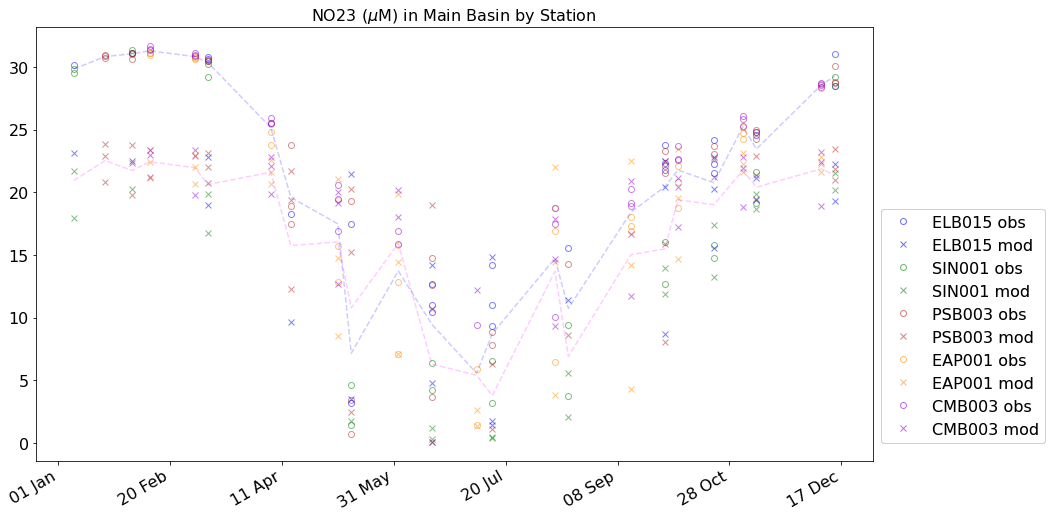

In [41]:
obsvar='NO23'
modvar='mod_nitrate'
start_date=1
end_date=365

fig, ax=plt.subplots(1,1,figsize=(15,8))
ps=TsByStation_full(ax,data,'Main Basin',obsvar,modvar)

#ts_trendline(ax,data,'South Basin',obsvar,modvar)
ts_avg_line(ax,data,obsvar,modvar,start_date,end_date,'Main Basin')
#ts_spline_line(ax,data,obsvar,modvar,start_date,end_date)


#might find it somewhat useful to use the alpha variable to make them semi transparent.
#Plotting a trendline for the whole region, but also able to see the point. 
start= dt.datetime(2010,1,1)
end=dt.datetime(2010,12,31)

## Individual Station Plots

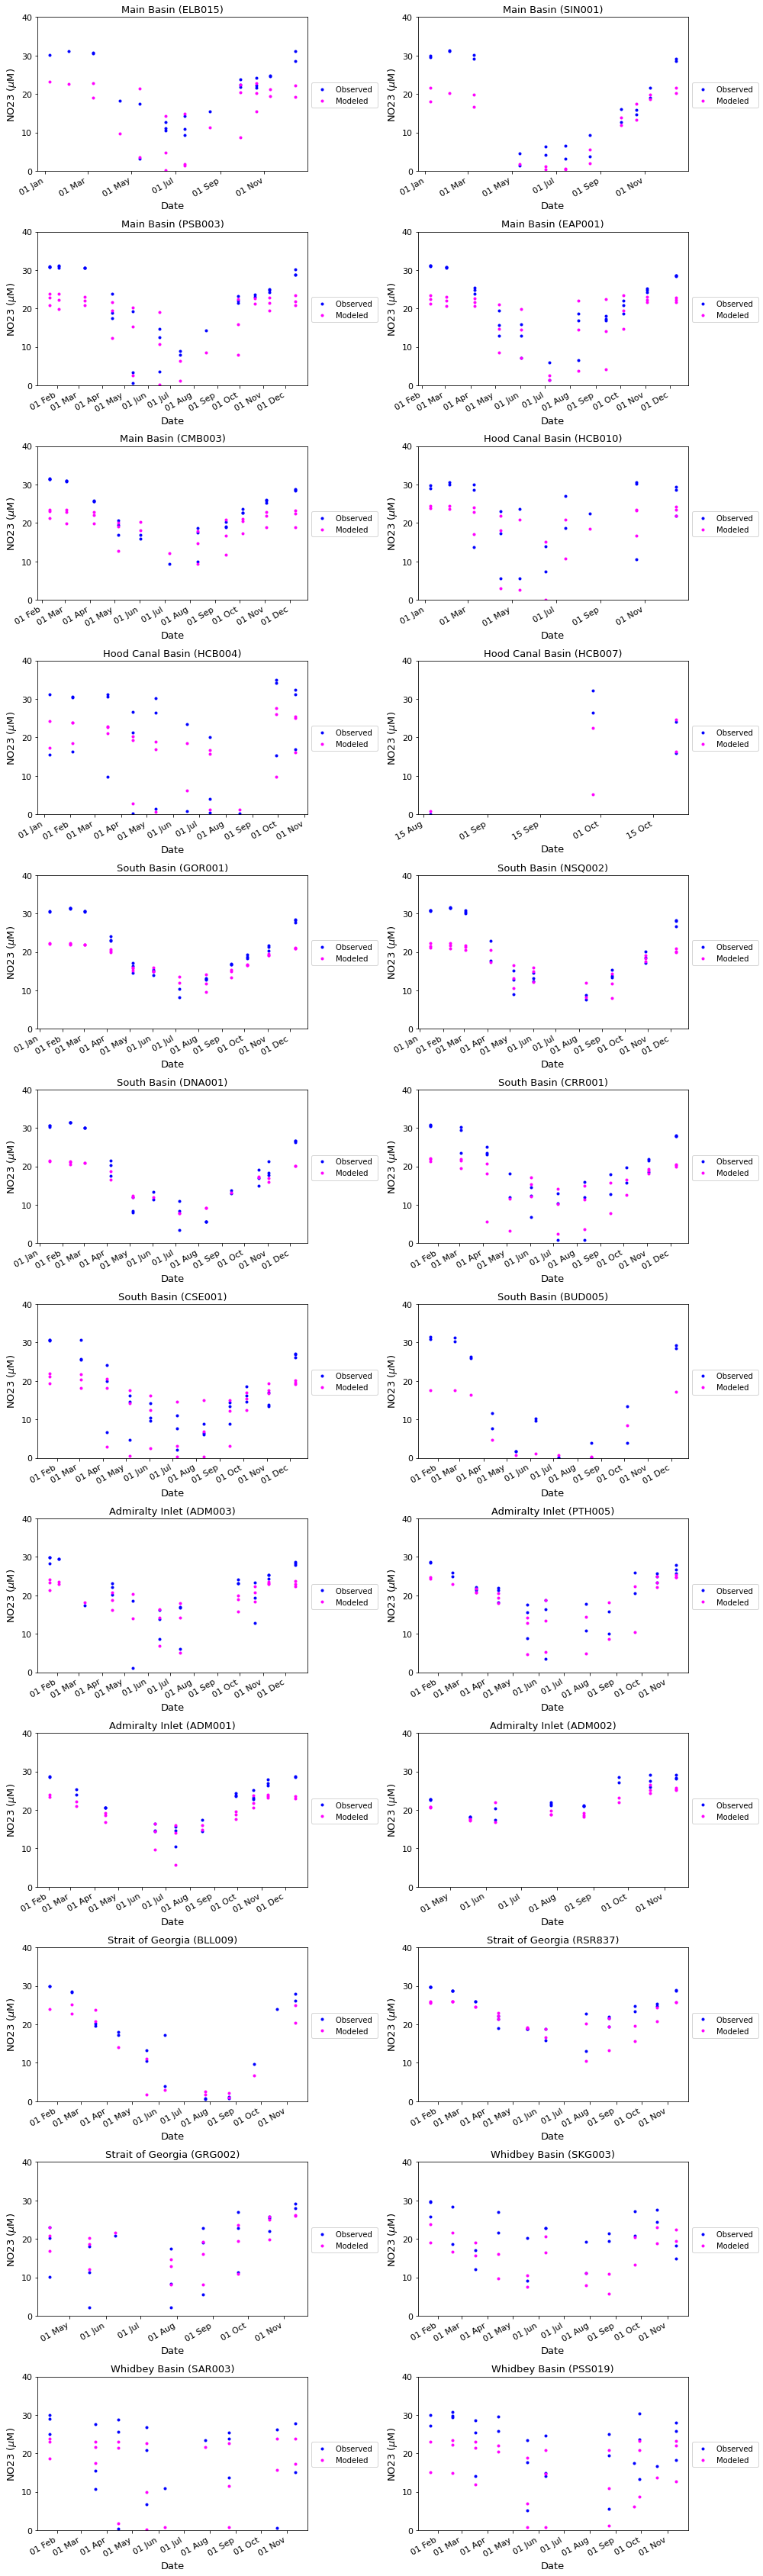

In [31]:
regions=data.Basin.unique()
lims=(0,40)
TsByStation_ind(data,datstat,regions,obsvar,modvar,year,lims,figsize=(14,47))

these are good but also have a main plot that is following the idea of the other one. 

In [14]:
%%time
start= dt.datetime(2010,1,1)
end=dt.datetime(2010,12,31) # the code called below (evaltools.index_model_files) includes the end date 
                          # in the values returned
basedir='/results2/SalishSea/nowcast-green.201905/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
ftype= 'ptrc_T' # load bio files
tres=24 # 1: hourly resolution; 24: daily resolution   <- try changing to 1 and loading hourly data
flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
# flist contains paths: file pathes; t_0 timestemp of start of each file; t_n: timestamp of start of next file
print(flist)

                                                 paths        t_0        t_n
0    /results2/SalishSea/nowcast-green.201905/01jan... 2010-01-01 2010-01-02
1    /results2/SalishSea/nowcast-green.201905/02jan... 2010-01-02 2010-01-03
2    /results2/SalishSea/nowcast-green.201905/03jan... 2010-01-03 2010-01-04
3    /results2/SalishSea/nowcast-green.201905/04jan... 2010-01-04 2010-01-05
4    /results2/SalishSea/nowcast-green.201905/05jan... 2010-01-05 2010-01-06
..                                                 ...        ...        ...
359  /results2/SalishSea/nowcast-green.201905/26dec... 2010-12-26 2010-12-27
360  /results2/SalishSea/nowcast-green.201905/27dec... 2010-12-27 2010-12-28
361  /results2/SalishSea/nowcast-green.201905/28dec... 2010-12-28 2010-12-29
362  /results2/SalishSea/nowcast-green.201905/29dec... 2010-12-29 2010-12-30
363  /results2/SalishSea/nowcast-green.201905/30dec... 2010-12-30 2010-12-31

[364 rows x 3 columns]
CPU times: user 12 ms, sys: 12 ms, total: 24 ms
Wall

In [15]:
# get model i,j of location S3 from places
ij,ii=places.PLACES['S3']['NEMO grid ji']
ik=0 # choose surface level

In [16]:
ii=data[data.Station == 'BUD005'].i.unique()[0]
ij=data[data.Station == 'BUD005'].j.unique()[0]
ik=0

In [17]:
bio=xr.open_mfdataset(flist['paths'])

In [19]:
%%time
tt=bio.time_counter
NO23=bio.nitrate.isel(deptht=ik,y=ij,x=ii)
#this is where we have the depth problem. 

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.81 ms


In [52]:
def TsByStation_ind2 (df,datstat,regions,obsvar,modvar,year,ylim,figsize=(14,40),loc='lower left',depth=5):  
    stations=[]
    for r in regions:
        sta0=df[df['Basin']==r].Station.unique()
        stations.append(sta0)
    stations = [val for sublist in stations for val in sublist]
    fig,ax=plt.subplots(math.ceil(len(stations)/2),2,figsize=figsize)
    new_stat = [stations[i:i+2] for i in range(0, len(stations), 2)]
    for si,axi in zip(new_stat,ax):
        for sj,axj in zip(si,axi):
            #The creation of the observed data points
            ps=[]
            obs0=et._deframe(df.loc[(df['dtUTC'] >= dt.datetime(year,1,1))&(df['dtUTC']<= dt.datetime(year,12,31))&(df['Station']==sj)&(df['Z']<=depth),[obsvar]])
            time0=et._deframe(df.loc[(df['dtUTC'] >= dt.datetime(year,1,1))&(df['dtUTC']<= dt.datetime(year,12,31))&(df['Station']==sj)&(df['Z']<=depth),['dtUTC']])
            p0,=axj.plot(time0,obs0,'.',color='blue',label=f'Observed {obsvar}',marker='o',fillstyle='none')
            ps.append(p0)
            # The creation of the model data line 
            ii=data[data.Station == sj].i.unique()[0]
            ij=data[data.Station == sj].j.unique()[0]
            ik=0
            tt=bio.time_counter
            NO23=bio[modvar].isel(deptht=ik,y=ij,x=ii)
            p0,=axj.plot(tt,NO23,'-',color='darkorange',label='Nitrate')
            ps.append(p0)
            #labeling and formatting
            axj.set_ylabel('Concentration ($\mu$M)')
            axj.set_xlim(tt[0],tt[-1])
            axj.legend(handles=ps,prop={'size': 10},loc=loc)
            axj.set_xlabel(f'Date',fontsize=13)
            axj.set_ylabel(f'{obsvar} ($\mu$M)',fontsize=13)
            axj.set_title(f'{df[df.Station==sj].Basin.unique()[0]} ({sj})', fontsize=13)
            axj.set_ylim(ylim)
            yearsFmt = mdates.DateFormatter('%d %b')
            axj.xaxis.set_major_formatter(yearsFmt)
            for tick in axj.xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            for tick in axj.yaxis.get_major_ticks():
                tick.label.set_fontsize(13)
            plt.tight_layout()
            plt.setp(axj.get_xticklabels(), rotation=30, horizontalalignment='right')

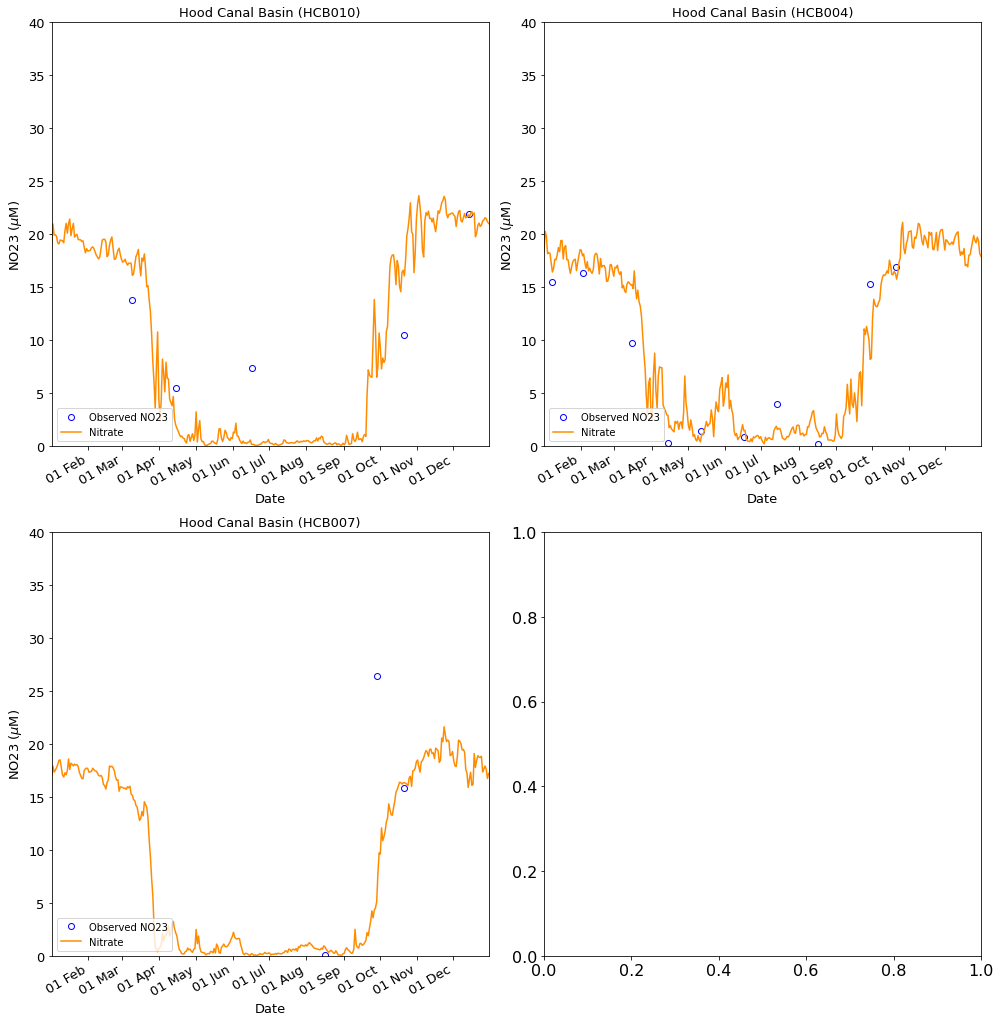

In [53]:
obsvar='NO23'
modvar='nitrate'
regions=['Hood Canal Basin']

TsByStation_ind2(data,datstat,regions,obsvar,modvar,year,lims,figsize=(14,14),loc='lower left')

Hmmm The fact that there are multiple different points at different depths make this technique mostly useless. Even if I fix it so that there are multiple lines or something, it will take so long it will be almost useless. Perhaps If I only look at observations at a certain depth it can be at least a little helpful. 